# Wahana Cerdas Chatbot

### Install Library

In [1]:
import random
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
import json
import nltk
import time
import re
import swifter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import transformers
from transformers import BertTokenizer
from transformers import TFBertForSequenceClassification

from nltk.stem import WordNetLemmatizer
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Input, Embedding, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D

from urllib import request

import warnings
warnings.filterwarnings("ignore")

'''# Package sentence tokenizer
nltk.download('punkt') 
# Package lemmatization
nltk.download('wordnet')
# Package multilingual wordnet data
nltk.download('omw-1.4')'''

"# Package sentence tokenizer\nnltk.download('punkt') \n# Package lemmatization\nnltk.download('wordnet')\n# Package multilingual wordnet data\nnltk.download('omw-1.4')"

### Data Acquisition

In [2]:
url = "https://raw.githubusercontent.com/Handepp/Tugas-Akhir-Chatbot/main/Dataset/Data%20Wahana.json"
request.urlretrieve(url, "Data%20Wahana.json")

('Data%20Wahana.json', <http.client.HTTPMessage at 0x247056eb790>)

In [3]:
# Importing the dataset
with open('Data%20Wahana.json') as content:
  data1 = json.load(content)

# Mendapatkan semua data ke dalam list
tags = [] # data tag
inputs = [] # data input atau pattern
responses = {} # data respon
words = [] # Data kata 
classes = [] # Data Kelas atau Tag
documents = [] # Data Kalimat Dokumen
ignore_words = ['?', '!'] # Mengabaikan tanda spesial karakter

for intent in data1['intents']:
  responses[intent['tag']]=intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))
      # add to our classes list
      if intent['tag'] not in classes:
        classes.append(intent['tag'])

# Konversi data json ke dalam dataframe
data = pd.DataFrame({"patterns":inputs, "tags":tags})

In [4]:
# Cetak data keseluruhan
data 

,patterns,tags
0,Siapa kamu?,Wardas.siapa
1,Kamu siapa?,Wardas.siapa
2,Ini apa?,Wardas.siapa
3,Kamu apa?,Wardas.siapa
4,Robot apakah kamu?,Wardas.siapa
...,...,...
186,Beritahu dayamu,wardas.Baterai
187,Beritahu nilai baterai mu,wardas.Baterai
188,Berapa lagi baterai yang kamu miliki,wardas.Baterai
189,Jumlah kapasitas bateraimu,wardas.Baterai


In [5]:
data.tags.value_counts()

Wardas.siapa          15
wardas.buruk          11
wardas.usia           10
wardas.hari            8
wardas.beban           7
wardas.tanggal         7
wardas.terimakasih     7
wardas.lokasi          7
wardas.Baterai         7
wardas.insaf           7
wardas.sapa            6
wardas.fast            6
wardas.medium          6
wardas.slow            6
wardas.jam             6
wardas.benar           5
wardas.hobby           5
wardas.bos             5
wardas.bantu           5
wardas.berpisah        5
wardas.hump            5
wardas.ngobrol         5
wardas.suhu            5
wardas.siap            5
wardas.baik            5
wardas.asal            5
wardas.sore            5
wardas.pagi            5
wardas.siang           5
wardas.malam           5
Name: tags, dtype: int64

In [6]:
# sort classes
classes = sorted(list(set(classes)))
print (len(classes), "classes", classes)

30 classes ['Wardas.siapa', 'wardas.Baterai', 'wardas.asal', 'wardas.baik', 'wardas.bantu', 'wardas.beban', 'wardas.benar', 'wardas.berpisah', 'wardas.bos', 'wardas.buruk', 'wardas.fast', 'wardas.hari', 'wardas.hobby', 'wardas.hump', 'wardas.insaf', 'wardas.jam', 'wardas.lokasi', 'wardas.malam', 'wardas.medium', 'wardas.ngobrol', 'wardas.pagi', 'wardas.sapa', 'wardas.siang', 'wardas.siap', 'wardas.slow', 'wardas.sore', 'wardas.suhu', 'wardas.tanggal', 'wardas.terimakasih', 'wardas.usia']


### Preprocessing

In [7]:
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  #text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()                               # Menghapus whitespaces
  return text

In [8]:
key= "https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv"
request.urlretrieve(key, "key_norm.csv")
key_norm = pd.read_csv('key_norm.csv')
print(key_norm.head())

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


In [9]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

In [10]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [11]:
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = stemming(text)
  return text

In [12]:
%%time
data['patterns'] = data['patterns'].swifter.apply(text_preprocessing_process)

Pandas Apply:   0%|          | 0/191 [00:00<?, ?it/s]

CPU times: total: 3.25 s
Wall time: 3.3 s


In [13]:
data

,patterns,tags
0,siapa kamu,Wardas.siapa
1,kamu siapa,Wardas.siapa
2,ini apa,Wardas.siapa
3,kamu apa,Wardas.siapa
4,robot apakah kamu,Wardas.siapa
...,...,...
186,beritahu daya,wardas.Baterai
187,beritahu nilai baterai mu,wardas.Baterai
188,berapa lagi baterai yang kamu milik,wardas.Baterai
189,jumlah kapasitas baterai,wardas.Baterai


## BERT

In [14]:
labelencoder = LabelEncoder()
data['tags'] = labelencoder.fit_transform(data['tags'])

In [15]:
df_train, df_test = train_test_split(data, test_size=0.35)
df_val, df_test = train_test_split(df_test, test_size=0.35)

df_train.shape, df_test.shape, df_val.shape

((124, 2), (24, 2), (43, 2))

In [16]:
# Tentukan pre-trained model yang akan digunakan untuk fine-tuning
# Daftar model dapat ditemukan pada https://huggingface.co

PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'  # https://huggingface.co/indobenchmark/indobert-base-p2
bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)  # Load tokenizer dari pre-trained model
vocabulary = bert_tokenizer.get_vocab()

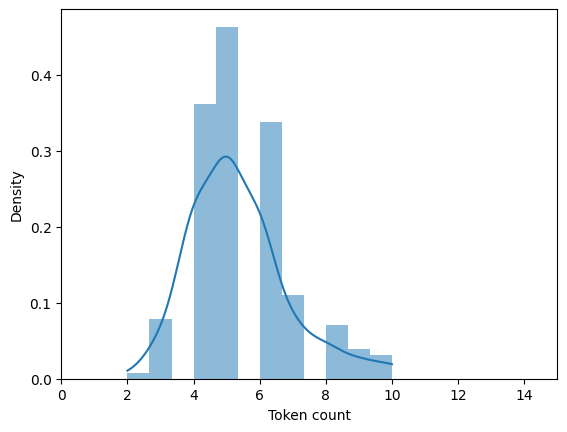

In [17]:
token_lens = []

for txt in data.patterns:
  tokens = bert_tokenizer.encode(txt)
  token_lens.append(len(tokens))

sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 15]);
plt.xlabel('Token count');

In [18]:
MAX_LEN = 11

In [19]:
def convert_example_to_feature(sentence):  
  return bert_tokenizer.encode_plus(
      sentence, 
      add_special_tokens = True, 
      padding = 'max_length',
      truncation = 'longest_first',
      max_length = MAX_LEN, 
      return_attention_mask = True, 
      return_token_type_ids=True
    )

def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
  return {
      "input_ids": input_ids,               # Sebagai token embedding
      "token_type_ids": token_type_ids,     # Sebagai segment embedding
      "attention_mask": attention_masks,    # Sebagai filter informasi mana yang kalkulasi oleh model
  }, label

# Buat fungsi untuk iterasi pada setiap kalimat pada keseluruhan data
def encode(data):
  input_ids_list = []
  token_type_ids_list = []
  attention_mask_list = []
  label_list = []
    
  for sentence, label in data.to_numpy():

    bert_input = convert_example_to_feature(sentence)
  
    input_ids_list.append(bert_input['input_ids'])
    token_type_ids_list.append(bert_input['token_type_ids'])
    attention_mask_list.append(bert_input['attention_mask'])
    label_list.append([label])

  return tf.data.Dataset.from_tensor_slices((input_ids_list, attention_mask_list, token_type_ids_list, label_list)).map(map_example_to_dict)

In [20]:
EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 5e-5

In [21]:
# Lakukan input formatting menggunakan fungsi sebelumnya pada data keseluruhan data
train_encoded = encode(df_train).batch(BATCH_SIZE)
test_encoded = encode(df_test).batch(BATCH_SIZE)
val_encoded = encode(df_val).batch(BATCH_SIZE)

In [22]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=30)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

# Karena tidak menggunakan one-hot vectors, sehingga loss function dapat menggunakan sparse categorical cross entropy
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile model
bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
%%time
bert_history = bert_model.fit(train_encoded, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_encoded)

Epoch 1/50
4/4 [==============================] - 19s 1s/step - loss: 3.3980 - accuracy: 0.1129 - val_loss: 2.9657 - val_accuracy: 0.3023
Epoch 2/50
4/4 [==============================] - 1s 260ms/step - loss: 2.7399 - accuracy: 0.3871 - val_loss: 2.5909 - val_accuracy: 0.4419
Epoch 3/50
4/4 [==============================] - 1s 260ms/step - loss: 2.1767 - accuracy: 0.7177 - val_loss: 2.1673 - val_accuracy: 0.6047
Epoch 4/50
4/4 [==============================] - 1s 285ms/step - loss: 1.7066 - accuracy: 0.8871 - val_loss: 1.7984 - val_accuracy: 0.6744
Epoch 5/50
4/4 [==============================] - 1s 259ms/step - loss: 1.2855 - accuracy: 0.9435 - val_loss: 1.5115 - val_accuracy: 0.7907
Epoch 6/50
4/4 [==============================] - 1s 261ms/step - loss: 0.9904 - accuracy: 0.9758 - val_loss: 1.2606 - val_accuracy: 0.8605
Epoch 7/50
4/4 [==============================] - 1s 270ms/step - loss: 0.7233 - accuracy: 0.9919 - val_loss: 1.0468 - val_accuracy: 0.8605
Epoch 8/50
4/4 [======

In [28]:
# Buat fungsi untuk plotting hasil training
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

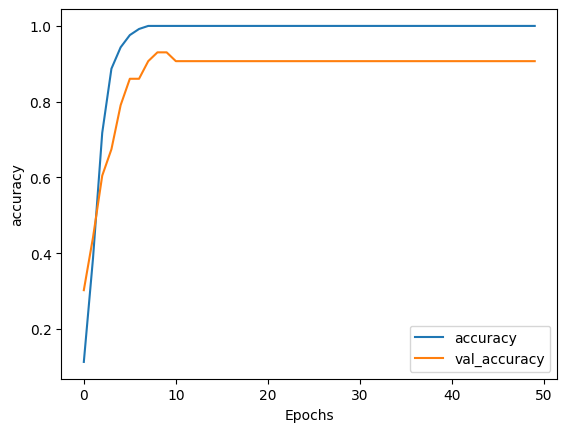

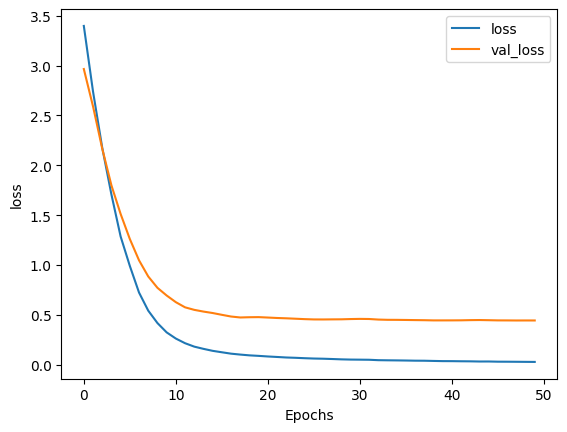

In [25]:
plot_graphs(bert_history, 'accuracy')
plot_graphs(bert_history, 'loss')

In [29]:
bert_model.save_weights('Model/bert-wardas.h5')

In [27]:
score = bert_model.evaluate(test_encoded)

print("Test Accuracy:", score[1])

1/1 [==============================] - 0s 91ms/step - loss: 0.3365 - accuracy: 0.9167
Test Accuracy: 0.9166666865348816
